In [189]:
from tqdm import tqdm
import math
import os
import numpy as np
import pandas as pd
import torch
import gpytorch
import matplotlib.pyplot as plt

#### Starting with just call data

In [192]:
calls = pd.read_csv("SPY_calls.csv")
calls['T'] = calls['T'].astype(np.float32)
calls['mny'] = calls['moneyness'].astype(np.float32)
calls['iv'] = calls['implied_volatility'].astype(np.float32)

calls['e_iv'] = math.e ** calls['iv']




calls['st_T'] = (calls['T'] - calls['T'].mean())/calls['T'].std()
calls['st_mny'] = (calls['mny'] - calls['mny'].mean())/calls['mny'].std()


#calls['st_iv'] = (calls['iv'] - calls['iv'].mean())/calls['iv'].std()

In [193]:
x = torch.tensor(calls[['st_T', 'st_mny']].values)
y = torch.tensor(calls[['e_iv']].values)
print(x[:5])
print(y[:5])

tensor([[-0.9358, -3.0385],
        [-0.9358, -1.8999],
        [-0.9358, -1.5709],
        [-0.9358, -1.5203],
        [-0.9358, -1.3938]])
tensor([[1.8294],
        [1.3470],
        [1.2781],
        [1.2707],
        [1.2718]])


In [194]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)

In [195]:
train_y = train_y.reshape((len(train_y)))
test_y = test_y.reshape((len(test_y)))

####  GP Regression

In [241]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [242]:
# this is for running the notebook in our testing framewor
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

losses = []

training_iter = 65
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    #print(len(loss))
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    losses.append(loss.item())
    optimizer.step()

Iter 1/70 - Loss: 0.744   lengthscale: 0.693   noise: 0.693
Iter 2/70 - Loss: 0.707   lengthscale: 0.744   noise: 0.644
Iter 3/70 - Loss: 0.670   lengthscale: 0.798   noise: 0.598
Iter 4/70 - Loss: 0.631   lengthscale: 0.854   noise: 0.554
Iter 5/70 - Loss: 0.592   lengthscale: 0.911   noise: 0.513
Iter 6/70 - Loss: 0.551   lengthscale: 0.970   noise: 0.474
Iter 7/70 - Loss: 0.511   lengthscale: 1.030   noise: 0.437
Iter 8/70 - Loss: 0.469   lengthscale: 1.091   noise: 0.403
Iter 9/70 - Loss: 0.427   lengthscale: 1.152   noise: 0.370
Iter 10/70 - Loss: 0.384   lengthscale: 1.215   noise: 0.340
Iter 11/70 - Loss: 0.341   lengthscale: 1.278   noise: 0.312
Iter 12/70 - Loss: 0.296   lengthscale: 1.341   noise: 0.286
Iter 13/70 - Loss: 0.252   lengthscale: 1.402   noise: 0.261
Iter 14/70 - Loss: 0.207   lengthscale: 1.463   noise: 0.239
Iter 15/70 - Loss: 0.161   lengthscale: 1.523   noise: 0.218
Iter 16/70 - Loss: 0.115   lengthscale: 1.582   noise: 0.199
Iter 17/70 - Loss: 0.068   length

/Users/adammoszczynski/miniforge3/envs/vol2/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.2908518314361572 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 68/70 - Loss: -2.329   lengthscale: 0.930   noise: 0.001


KeyboardInterrupt: 

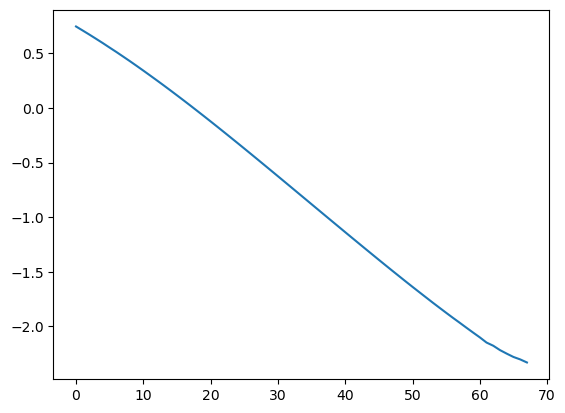

In [243]:
plt.plot(range(len(losses)), losses)
plt.show()

In [244]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    
torch.sqrt(torch.mean(torch.pow(observed_pred.mean - test_y, 2)))

/Users/adammoszczynski/miniforge3/envs/vol2/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.03411409631371498 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


tensor(0.0211)

#### Testing full moneyness spectrum on custom time to expriation

In [245]:
mny = np.array(np.linspace(0.7, 1.3, 100)).astype(np.float32)
mny = (mny - calls['mny'].mean()) / calls['mny'].std()
t = np.array([18]*100).astype(np.float32)
t = (t - calls['T'].mean())/calls['T'].std()
#mny = 

sample = torch.tensor([t, mny]).T#.reshape((1000, 2))
print(sample[:5])

tensor([[-0.9358, -3.7320],
        [-0.9358, -3.6657],
        [-0.9358, -3.5994],
        [-0.9358, -3.5331],
        [-0.9358, -3.4668]])


In [246]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(sample))

In [257]:
insamp_mny = train_x[train_x[:, 0] == (18 - calls['T'].mean()) / calls['T'].std()][:, 1]
insamp_iv = np.log(train_y[train_x[:, 0] == (18 - calls['T'].mean()) / calls['T'].std()])

oos_mny = test_x[test_x[:, 0] == (18 - calls['T'].mean()) / calls['T'].std()][:, 1]
oos_iv = np.log(test_y[test_x[:, 0] == (18 - calls['T'].mean()) / calls['T'].std()])

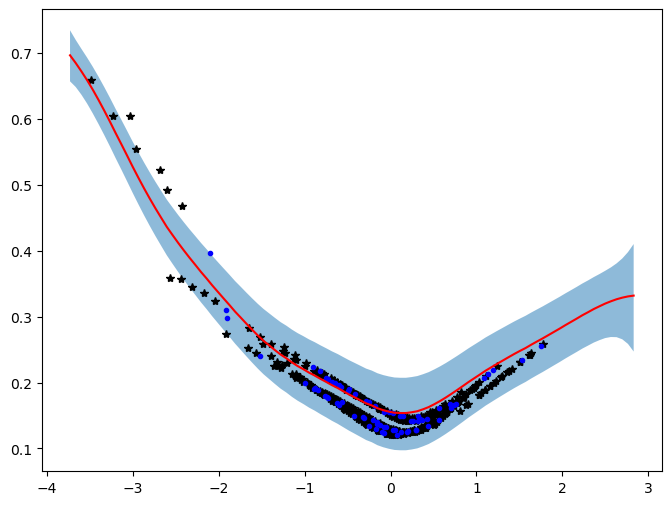

In [263]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    #ax.plot(calls['st_mny'][calls['T']==18], calls['iv'][calls['T']==18], 'k*')
    ax.plot(insamp_mny, insamp_iv, 'k*')
    ax.plot(oos_mny, oos_iv, 'b.')
    # Plot predictive means as blue line
    
    # undo scaling
    lower = np.log(lower.numpy())
    upper = np.log(upper.numpy() ) 
    preds = np.log(observed_pred.mean.numpy())
    
    
    
    #ax.plot(mny, observed_pred.mean.numpy(), 'b')
    ax.plot(mny, preds, 'r')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(mny, lower.numpy(), upper.numpy(), alpha=0.5)
    ax.fill_between(mny, lower, upper, alpha=0.5)
    #ax.set_ylim([-3, 3])
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])